# Image Classification on CIFAR-10
In this notebook we will explore different deep learning architectures for image classification on the CIFAR-10 dataset. We will accomplish a couple of things:

1. For a fully-connected output with 1 fully-connected hidden layer, we have one hidden layer denoted as $x_{hidden} \in \mathbb{R}^M$, where $M$ will be a hyperparameter that can be chosen to be in the hundreds. The nonlinearity applied to the hidden layer will be the rectified linear unit (ReLU) defined as ReLU(x) = max{0, x}.This network can be written as $$x_{out} = W_2ReLU(W_1(x_{in}) + b_1) + b_2$$, where $W_1 \in \mathbb{R}^{M \times 3072}$, $b_1 \in \mathbb{R}^M$, $W_2 \in \mathbb{R}^{10 \times M}$, and $b_2 \in \mathbb{R}^{10}$. To achieve a validation accuracy of roughly 50%, we need to tune the different hyperparameters and train the network for a sufficient number of epochs. The hyperparameter configuration used to achieve this performance will be provided.

2. A convolutional layer with max-pool and fully-connected output can be represented as follows: Let W1 be a convolutional layer with filters of size k x k x 3 and M filters, where reasonable choices for M and k are 100 and 5, respectively. Then, we have that Conv2d$(xin, W1) \in \mathbb{R}^{(33-k)\times(33-k)\times M}$. Each convolution will have its own offset applied to each of the output pixels of the convolution, denoted as Conv2d$(x^{in}, W) + b1$, where $b_1$ is parameterized in $\mathbb{R}^M$. Finally, we apply a ReLU activation function to the result of the convolutional layer. The network can be written as: $$x_{output} = W_2 \left( \text{MaxPool} \left( \text{relu} \left( \text{Conv2d} \left( x_{input}, W_1 \right) + b_1 \right) \right) \right) + b $$ We will be looking for a validation accuracy of roughly 65%.



In [1]:
import torch
from torch import nn
import numpy as np

from typing import Tuple, Union, List, Callable
from torch.optim import SGD
import torchvision
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline 

Let's verify that we are using a gpu:

In [2]:
assert torch.cuda.is_available(), "GPU is not available"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)  # this should print out CUDA

cuda


# Load the dataset
Let's load CIFAR-10 data.

In [350]:
train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


Here, we'll use the torch `DataLoader` to wrap our datasets. `DataLoader`s handle batching, shuffling, and iterating over data; they can also be useful for building more complex input pipelines that perform transfoermations such as data augmentation.

Due to the demand of training time I will make two train and validate sets. Our standard train/validate split is going to be 90/10. Instead I will just use 10/10 and then throw away the remaining 80% of the data for the hyperparameter tuning. Once I have found hyperparameters I will run the model on the full train set. Note that this may give 'suboptimal' hyperparameters compared to searching on the full train set.

In [351]:
batch_size = 128

train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [352]:
batch_size = 128

small_train_dataset, small_val_dataset, throw_away = random_split(train_dataset, [int(0.1 * len(train_dataset)), int( 0.1 * len(train_dataset)), int(0.8*len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader_small = DataLoader(
    small_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader_small = DataLoader(
    small_val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader_small = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

Before we get started, let's take a look at our data to get an understanding of what we are doing. CIFAR-10 is a dataset containing images split into 10 classes.

A single batch of images has shape: torch.Size([128, 3, 32, 32])
A single RGB image has 3 channels, width 32, and height 32.
Size of a batch of images flattened with view: torch.Size([128, 3072])
Size of a batch of images flattened with flatten: torch.Size([128, 3072])
True
This image is labeled as class airplane


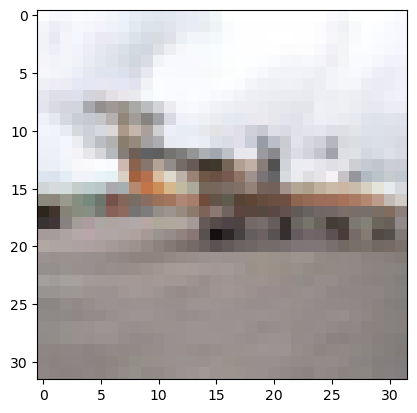

In [333]:
imgs, labels = next(iter(train_loader))
print(f"A single batch of images has shape: {imgs.size()}")
example_image, example_label = imgs[0], labels[0]
c, w, h = example_image.size()
print(f"A single RGB image has {c} channels, width {w}, and height {h}.")

# This is one way to flatten our images
batch_flat_view = imgs.view(-1, c * w * h)
print(f"Size of a batch of images flattened with view: {batch_flat_view.size()}")

# This is another equivalent way
batch_flat_flatten = imgs.flatten(1)
print(f"Size of a batch of images flattened with flatten: {batch_flat_flatten.size()}")

# The new dimension is just the product of the ones we flattened
d = example_image.flatten().size()[0]
print(c * w * h == d)

# View the image
t =  torchvision.transforms.ToPILImage()
plt.imshow(t(example_image))

# These are what the class labels in CIFAR-10 represent. For more information,
# visit https://www.cs.toronto.edu/~kriz/cifar.html
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
           "horse", "ship", "truck"]
print(f"This image is labeled as class {classes[example_label]}")


In this problem, we will attempt to predict what class an image is labeled as.

# Fully Connected NN w/ 1 layer (wide neural net)
First, let's create the fully connected NN with 1 hidden layer. We will have the size of the hidden layer be the hyperparamter M.

In [48]:
def fully_connected(M: int) -> nn.Module:
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(3072, M),
        nn.ReLU(),
        nn.Linear(M, 10)
    )
    return model.to(DEVICE)

Let's define a method to train this model using SGD as our optimizer.

In [46]:
def train(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
    )-> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains a model for the specified number of epochs using the loaders.

    Returns: 
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
    """

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        # Main training loop; iterate over train_loader. The loop
        # terminates when the train loader finishes iterating, which is one epoch.
        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))

    return train_losses, train_accuracies, val_losses, val_accuracies


In [298]:
#Check if the train function works

model = fully_connected(50)
optimizer = SGD(model.parameters(), 0.05)

train(model, optimizer = optimizer, train_loader = train_loader_small, val_loader = val_loader_small, epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

([2.226575933653733,
  2.106208184669758,
  2.0517236405405503,
  1.9936506378239598,
  1.9599233372458096,
  1.9191480505055394,
  1.9190702849421009,
  1.9097147316768253,
  1.8672046414737045,
  1.8514251133491253],
 [0.16648706896551724,
  0.22225215517241378,
  0.2543103448275862,
  0.2634698275862069,
  0.2974137931034483,
  0.3041487068965517,
  0.3036099137931034,
  0.3068426724137931,
  0.3192349137931034,
  0.3302801724137931],
 [2.233633986834822,
  2.0704296786209633,
  2.068704868185109,
  2.0030593296577193,
  1.9814749709491073,
  2.090043487219975,
  1.9385942138474563,
  1.940429868369267,
  2.0775221791760674,
  1.8742775177133495],
 [0.1584051724137931,
  0.25700431034482757,
  0.22332974137931033,
  0.27424568965517243,
  0.2685883620689655,
  0.23329741379310345,
  0.2874461206896552,
  0.29364224137931033,
  0.2626616379310345,
  0.3308189655172414])

# WNN hyperparameter tuning

Optuna is extremely nice for hyperparameter searches.  Lets create a basic study using the smaller dataset so it trains relatively quickly. Optuna uses baeysian search so it should technically find more optimal hyperparameters quicker than grid or random search. 

In [87]:
import optuna
def fully_connected_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log = True)
    Ms = trial.suggest_int('M', 100,1500)
    
    model = fully_connected(M = Ms)
    optimizer = SGD(model.parameters(), learning_rate)
        
    train_losses, train_accuracies, val_losses, val_accuracies = train(model, optimizer, train_loader_small, val_loader_small, epochs = 15)
    
    return(val_accuracies[-1])

study_nn = optuna.create_study(direction = 'maximize')
study_nn.optimize(fully_connected_objective, n_trials = 30)

[I 2023-03-14 15:26:52,027] A new study created in memory with name: no-name-7c6f005e-b63f-4e24-8885-2e6f6c369412


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:27:21,347] Trial 0 finished with value: 0.33001077586206895 and parameters: {'learning_rate': 0.02060455955681592, 'M': 757}. Best is trial 0 with value: 0.33001077586206895.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:27:50,616] Trial 1 finished with value: 0.34375 and parameters: {'learning_rate': 0.024301058780475754, 'M': 1012}. Best is trial 1 with value: 0.34375.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:28:17,585] Trial 2 finished with value: 0.2505387931034483 and parameters: {'learning_rate': 0.003532003450566337, 'M': 143}. Best is trial 1 with value: 0.34375.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:28:47,103] Trial 3 finished with value: 0.34913793103448276 and parameters: {'learning_rate': 0.0419173079624403, 'M': 823}. Best is trial 3 with value: 0.34913793103448276.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:29:17,315] Trial 4 finished with value: 0.3588362068965517 and parameters: {'learning_rate': 0.051956525536124405, 'M': 979}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:29:46,712] Trial 5 finished with value: 0.3125 and parameters: {'learning_rate': 0.08283097383688497, 'M': 769}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:30:15,690] Trial 6 finished with value: 0.2801724137931034 and parameters: {'learning_rate': 0.0037663821790539843, 'M': 612}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:30:44,017] Trial 7 finished with value: 0.2890625 and parameters: {'learning_rate': 0.09728195096108615, 'M': 409}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:31:11,727] Trial 8 finished with value: 0.3025323275862069 and parameters: {'learning_rate': 0.018564416652869755, 'M': 300}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:31:40,654] Trial 9 finished with value: 0.33216594827586204 and parameters: {'learning_rate': 0.021898233284751573, 'M': 536}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:32:12,526] Trial 10 finished with value: 0.2588900862068966 and parameters: {'learning_rate': 0.001775855028831536, 'M': 1483}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:32:42,796] Trial 11 finished with value: 0.3494073275862069 and parameters: {'learning_rate': 0.04937233238867073, 'M': 1084}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:33:13,138] Trial 12 finished with value: 0.2842133620689655 and parameters: {'learning_rate': 0.04957718822964586, 'M': 1142}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:33:43,665] Trial 13 finished with value: 0.31438577586206895 and parameters: {'learning_rate': 0.011398993448359155, 'M': 1259}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:34:13,064] Trial 14 finished with value: 0.3308189655172414 and parameters: {'learning_rate': 0.049463464281658355, 'M': 997}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:34:42,797] Trial 15 finished with value: 0.3407866379310345 and parameters: {'learning_rate': 0.044564890538806544, 'M': 1246}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:35:12,809] Trial 16 finished with value: 0.3230064655172414 and parameters: {'learning_rate': 0.010564611263775083, 'M': 1497}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:35:42,169] Trial 17 finished with value: 0.3108836206896552 and parameters: {'learning_rate': 0.08995649601360375, 'M': 965}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:36:12,063] Trial 18 finished with value: 0.31950431034482757 and parameters: {'learning_rate': 0.034435099152041994, 'M': 1157}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:36:41,513] Trial 19 finished with value: 0.3407866379310345 and parameters: {'learning_rate': 0.06409856181811871, 'M': 1358}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:37:10,847] Trial 20 finished with value: 0.3375538793103448 and parameters: {'learning_rate': 0.03507023003325991, 'M': 901}. Best is trial 4 with value: 0.3588362068965517.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:37:40,145] Trial 21 finished with value: 0.38200431034482757 and parameters: {'learning_rate': 0.06779561769476368, 'M': 844}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:38:08,937] Trial 22 finished with value: 0.32947198275862066 and parameters: {'learning_rate': 0.0632262027120467, 'M': 654}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:38:39,151] Trial 23 finished with value: 0.3415948275862069 and parameters: {'learning_rate': 0.0665048932007465, 'M': 1074}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:39:08,778] Trial 24 finished with value: 0.3130387931034483 and parameters: {'learning_rate': 0.03166171989070559, 'M': 897}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:39:39,141] Trial 25 finished with value: 0.32623922413793105 and parameters: {'learning_rate': 0.09776245196807334, 'M': 1104}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:40:07,926] Trial 26 finished with value: 0.3275862068965517 and parameters: {'learning_rate': 0.05970551425119402, 'M': 670}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:40:36,966] Trial 27 finished with value: 0.3246228448275862 and parameters: {'learning_rate': 0.029674779783974824, 'M': 834}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:41:07,486] Trial 28 finished with value: 0.33001077586206895 and parameters: {'learning_rate': 0.016516833532262028, 'M': 1207}. Best is trial 21 with value: 0.38200431034482757.


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-03-14 15:41:39,034] Trial 29 finished with value: 0.3521012931034483 and parameters: {'learning_rate': 0.04371137916714027, 'M': 1374}. Best is trial 21 with value: 0.38200431034482757.


# Train and plot
Now that we have our hyperparameters from optuna we can train and test our model. Lets see how it does.

In [89]:
best_lr = study_nn.best_params['learning_rate']
best_M = study_nn.best_params['M']
nn_model_best = fully_connected(best_M)
nn_optimizer_best = SGD(nn_model_best.parameters(), best_lr)

train_losses, train_accuracies, val_losses, val_accuracies = train(model = nn_model_best, optimizer = nn_optimizer_best, train_loader = train_loader, val_loader = val_loader, epochs = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

In [94]:
val_accuracies[-5:-1]

[0.4716796875, 0.51123046875, 0.4873046875, 0.4931640625]

Plot the training and validation accuracy for each epoch.

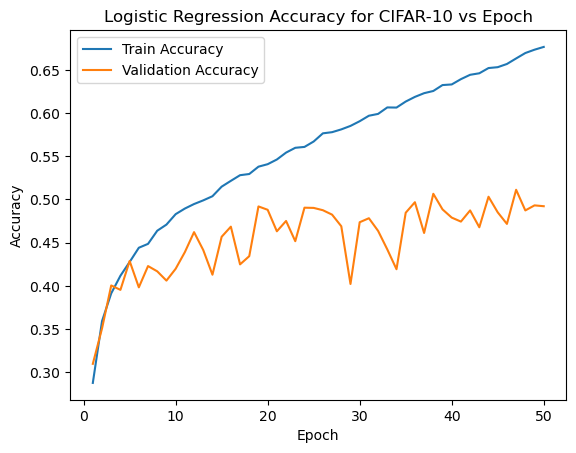

In [91]:
epochs = range(1, len(train_accuracies)+1)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Wide NN for CIFAR-10 vs Epoch")
plt.show()

# Evaluate on Test set (WNN)
The last thing we have to do is batch_eval our model on the testing data.

In [41]:
def evaluate(
    model: nn.Module, loader: DataLoader
) -> Tuple[float, float]:
    """Computes test loss and accuracy of model on loader."""
    loss = nn.CrossEntropyLoss()
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for (batch, labels) in loader:
            batch, labels = batch.to(DEVICE), labels.to(DEVICE)
            y_batch_pred = model(batch)
            batch_loss = loss(y_batch_pred, labels)
            test_loss = test_loss + batch_loss.item()

            pred_max = torch.argmax(y_batch_pred, 1)
            batch_acc = torch.sum(pred_max == labels)
            test_acc = test_acc + batch_acc.item()
        test_loss = test_loss / len(loader)
        test_acc = test_acc / (batch_size * len(loader))
        return test_loss, test_acc

In [98]:
test_loss, test_acc = batch_eval(nn_model_best, test_loader)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.5024723101265823


# Results
Overall we did get to roughly 50% CV accuracy as well as 50% accuracy on the test set. We see from the training curve above that the learning rate was maybe a bit too big. I think that is something to keep in mind for the convolution neural network. Having a learning rate training schedule based off of the number of epochs is a fairly common method (which adds even more hyperparameters) so I will implement it for training the CNN.


# Convolution Neural Network (CNN)
We now take a look at a convolutional neural network. Out input is an image of 3x32x32. So we need to define a few things. The output size will be floor($M(\frac{(33-k)}{N})^2$). We have the size of the filter to be 3 x k x k and the number of filters as M. Finally, we apply a maxpool function to reduce the size by a factor of N.

In [212]:
# Convolution NN input is 3x32x32
#k = kernel size, M is number of filters, NxN is the size of the maxpool.
def Convolution_NN(M: int, k: int, N: int) -> nn.Module:
    output_size = M * ((32 - k + 1) // N) ** 2
    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=M, kernel_size=k, bias=True),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=N),
        nn.Flatten(),
        nn.Linear(output_size, 10)
    )
    return model.to(DEVICE)

### Check if it works

In [299]:
model = Convolution_NN(M = 100, k = 5, N = 14)
optimizer = SGD(model.parameters(), 0.001)

train(model, optimizer = optimizer, train_loader = train_loader_small, val_loader = val_loader_small, epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

([2.3101783045407,
  2.305279887955764,
  2.301445508825368,
  2.298263903321891,
  2.2964005634702485,
  2.295025134908742,
  2.2938216883560707,
  2.2927730083465576,
  2.2916691632106385,
  2.2910832207778404],
 [0.08782327586206896,
  0.08890086206896551,
  0.09240301724137931,
  0.09832974137931035,
  0.10183189655172414,
  0.10668103448275862,
  0.11988146551724138,
  0.12257543103448276,
  0.12473060344827586,
  0.13011853448275862],
 [2.302510195765002,
  2.2995360884173164,
  2.29704003498472,
  2.2955596364777664,
  2.29428218150961,
  2.293526320621885,
  2.2928624317563813,
  2.2920561905564933,
  2.2918456340658255,
  2.29095720422679],
 [0.09132543103448276,
  0.09267241379310345,
  0.09617456896551724,
  0.10129310344827586,
  0.10695043103448276,
  0.12122844827586207,
  0.1258081896551724,
  0.125,
  0.12688577586206898,
  0.12607758620689655])

# Hyper parameter tuning CNN

We have a series of hyperparamters for this model:
- M: The number of filters
- k: The size of the filters (3 x k x k)
- N: Size of the NxN maxpool func
- learning rate: learning rate for optimizer
- optimizer: actual optimizer itself (sgd, adam, rmsprop)

We will define possible values for each of these. We do note that it seems for the filter size values of 3, 5, or 7 seem to be the best. Anything higher than 7 seems to take too long and the values should be odd otherwise they may not be centered on a pixel. Additionally, N + k needs to be no greater than 33 for math purposes. However we should avoid that quite easily. 

Lets run a small study in optuna then take a look.

In [300]:
#Create the optuna objective
def Convolution_NN_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log = True)
    Ms = trial.suggest_int('M', 20,300)
    ks = trial.suggest_int('k', 3,7, step = 2)
    Ns = trial.suggest_int('N', 10,23)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    
    model = Convolution_NN(M = Ms, k = ks, N = Ns)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
        
    train_losses, train_accuracies, val_losses, val_accuracies = train(model, optimizer, train_loader_small, val_loader_small, epochs = 10)
    
    return(val_accuracies[-1])

study_nn = optuna.create_study(direction = 'maximize')
study_nn.optimize(Convolution_NN_objective, n_trials = 20)

[I 2023-03-15 09:34:15,993] A new study created in memory with name: no-name-0256698b-b87f-4653-80d5-c2a07633459e


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:34:36,091] Trial 0 finished with value: 0.12042025862068965 and parameters: {'learning_rate': 0.0036294528253405702, 'M': 131, 'k': 3, 'N': 15, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.12042025862068965.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:34:54,413] Trial 1 finished with value: 0.19369612068965517 and parameters: {'learning_rate': 0.03779181267540158, 'M': 32, 'k': 5, 'N': 15, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.19369612068965517.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:35:17,819] Trial 2 finished with value: 0.09671336206896551 and parameters: {'learning_rate': 0.11742100107425359, 'M': 172, 'k': 3, 'N': 15, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.19369612068965517.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:35:40,205] Trial 3 finished with value: 0.27478448275862066 and parameters: {'learning_rate': 0.02858502152708572, 'M': 254, 'k': 7, 'N': 16, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:36:02,159] Trial 4 finished with value: 0.16298491379310345 and parameters: {'learning_rate': 0.0023250253737611016, 'M': 152, 'k': 7, 'N': 11, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:36:20,017] Trial 5 finished with value: 0.18911637931034483 and parameters: {'learning_rate': 0.03668885991487249, 'M': 52, 'k': 3, 'N': 22, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:36:39,747] Trial 6 finished with value: 0.10344827586206896 and parameters: {'learning_rate': 0.20699481030381947, 'M': 87, 'k': 5, 'N': 22, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:37:03,001] Trial 7 finished with value: 0.09859913793103449 and parameters: {'learning_rate': 0.041884212130449454, 'M': 240, 'k': 5, 'N': 11, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:37:25,993] Trial 8 finished with value: 0.09940732758620689 and parameters: {'learning_rate': 0.0012557087109677477, 'M': 173, 'k': 7, 'N': 19, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:37:47,266] Trial 9 finished with value: 0.09590517241379311 and parameters: {'learning_rate': 0.107987356506784, 'M': 177, 'k': 7, 'N': 17, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:38:08,901] Trial 10 finished with value: 0.15867456896551724 and parameters: {'learning_rate': 0.00815770667195591, 'M': 296, 'k': 7, 'N': 18, 'optimizer': 'SGD'}. Best is trial 3 with value: 0.27478448275862066.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:38:30,163] Trial 11 finished with value: 0.3208512931034483 and parameters: {'learning_rate': 0.01576188421817021, 'M': 22, 'k': 5, 'N': 14, 'optimizer': 'Adam'}. Best is trial 11 with value: 0.3208512931034483.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:38:53,432] Trial 12 finished with value: 0.3666487068965517 and parameters: {'learning_rate': 0.012819559975329598, 'M': 249, 'k': 5, 'N': 13, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.3666487068965517.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:39:17,471] Trial 13 finished with value: 0.3642241379310345 and parameters: {'learning_rate': 0.011571617934099854, 'M': 228, 'k': 5, 'N': 13, 'optimizer': 'Adam'}. Best is trial 12 with value: 0.3666487068965517.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:39:41,504] Trial 14 finished with value: 0.3838900862068966 and parameters: {'learning_rate': 0.007706828396846198, 'M': 222, 'k': 5, 'N': 13, 'optimizer': 'Adam'}. Best is trial 14 with value: 0.3838900862068966.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:40:03,084] Trial 15 finished with value: 0.3995150862068966 and parameters: {'learning_rate': 0.006273486470239134, 'M': 296, 'k': 5, 'N': 10, 'optimizer': 'Adam'}. Best is trial 15 with value: 0.3995150862068966.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:40:26,055] Trial 16 finished with value: 0.48356681034482757 and parameters: {'learning_rate': 0.0055699315320352745, 'M': 287, 'k': 3, 'N': 10, 'optimizer': 'Adam'}. Best is trial 16 with value: 0.48356681034482757.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:40:49,198] Trial 17 finished with value: 0.5183189655172413 and parameters: {'learning_rate': 0.004979990911867639, 'M': 298, 'k': 3, 'N': 10, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.5183189655172413.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:41:11,882] Trial 18 finished with value: 0.4973060344827586 and parameters: {'learning_rate': 0.0038793241254154102, 'M': 276, 'k': 3, 'N': 10, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.5183189655172413.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-03-15 09:41:33,747] Trial 19 finished with value: 0.4253771551724138 and parameters: {'learning_rate': 0.0027119853629885486, 'M': 205, 'k': 3, 'N': 12, 'optimizer': 'Adam'}. Best is trial 17 with value: 0.5183189655172413.


This takes a very long time even on the small training and CV set using a small amount of epochs. I would like to use optunas pruning function where after each epoch it will check the accuracy compared to the other iterations and prune those that seem like they will not give good results. This will allow us to increase the number of epochs for hyperparameter tuning and the number of iterations to try and find an optimal hyperparameter setup while greatly reducing the search time. 

In order to do this I need a new training function and evaluate function that will work on a single epoch as opposed to the function above which works for some number of epochs as an input. Additionally, I will implement a learning rate scheduler to lower the learning rate as the number of epochs increases. This should give us a smoother curve and increase accuracy.

Lets implement the functions and run a huge hyperparameter search.

In [18]:
def train_epoch(model, optimizer, dataloader):
    model.train()
    train_loss = 0
    train_acc = 0
    total = 0
    
    for images, labels in dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        output = model(images)
        loss = torch.nn.functional.cross_entropy(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.shape[0]
        train_acc += (output.argmax(1) == labels).sum().item()
        total += images.shape[0]
        
    return train_loss / total, train_acc / total

In [19]:
def batch_eval(model, loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
                inputs, labels = data
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = torch.nn.functional.cross_entropy(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                total_loss += loss.item() * labels.size(0)
    accuracy = 100 * correct / total
    loss = total_loss / total
    return loss, accuracy

In [238]:
import torch.optim as optim
import optuna
from optuna.trial import TrialState

def Convolution_NN_objective(trial):
    #Potential hyper parameters
    initial_learning_rate = trial.suggest_float('initial_learning_rate', 0.001, 0.3, log = True)
    Ms = trial.suggest_int('M', 20,300)
    ks = trial.suggest_int('k', 3,7, step = 2)
    Ns = trial.suggest_int('N', 10,23)      
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    
    model = Convolution_NN(M = Ms, k = ks, N = Ns)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=initial_learning_rate)
    
    # Step decay schedule
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
        
    for epoch in range(50):
        train_losses, train_accuracies = train_epoch(model, optimizer, train_loader_small)
        val_losses, val_accuracies = batch_eval(model, val_loader_small)

        # Report intermediate results to Optuna
        trial.report(val_accuracies, epoch)

        # Prune trials that perform poorly based on intermediate results
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        lr_scheduler.step()

    return val_accuracies


study_nn = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study_nn.optimize(Convolution_NN_objective, n_trials=100, show_progress_bar = True)

[I 2023-03-14 19:26:15,441] A new study created in memory with name: no-name-a8ccd1d8-265a-4890-8073-f3e56066f757


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-03-14 19:28:08,481] Trial 0 finished with value: 31.577503429355282 and parameters: {'initial_learning_rate': 0.02220424241140854, 'M': 232, 'k': 7, 'N': 15, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 31.577503429355282.
[I 2023-03-14 19:30:06,611] Trial 1 finished with value: 45.8161865569273 and parameters: {'initial_learning_rate': 0.003567947637350851, 'M': 225, 'k': 7, 'N': 23, 'optimizer': 'Adam'}. Best is trial 1 with value: 45.8161865569273.
[I 2023-03-14 19:31:54,262] Trial 2 finished with value: 45.541838134430726 and parameters: {'initial_learning_rate': 0.002458014061795822, 'M': 102, 'k': 3, 'N': 15, 'optimizer': 'Adam'}. Best is trial 1 with value: 45.8161865569273.
[I 2023-03-14 19:32:04,027] Trial 3 pruned. 
[I 2023-03-14 19:34:22,087] Trial 4 finished with value: 50.97393689986283 and parameters: {'initial_learning_rate': 0.004370438765752221, 'M': 293, 'k': 3, 'N': 15, 'optimizer': 'Adam'}. Best is trial 4 with value: 50.97393689986283.
[I 2023-03-14

In [239]:
study_nn.best_params

{'initial_learning_rate': 0.0021240372005085838,
 'M': 300,
 'k': 7,
 'N': 11,
 'optimizer': 'Adam'}

# Final Model CNN

Now that we have our best parameters we can run the final model. We will need to implement a learning rate scheduler into our previous train function as it captures lots of values for plotting which is nice. We will do that then let it run & plot.

In [3]:
#Update train function with LR scheduler.
def train2(
    model: nn.Module, optimizer: SGD,
    train_loader: DataLoader, val_loader: DataLoader,
    epochs: int = 20
    )-> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Trains a model for the specified number of epochs using the loaders.

    Returns: 
    Lists of training loss, training accuracy, validation loss, validation accuracy for each epoch.
    """

    loss = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
    
    for e in tqdm(range(epochs)):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        # Main training loop; iterate over train_loader. The loop
        # terminates when the train loader finishes iterating, which is one epoch.
        for (x_batch, labels) in train_loader:
            x_batch, labels = x_batch.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            labels_pred = model(x_batch)
            batch_loss = loss(labels_pred, labels)
            train_loss = train_loss + batch_loss.item()

            labels_pred_max = torch.argmax(labels_pred, 1)
            batch_acc = torch.sum(labels_pred_max == labels)
            train_acc = train_acc + batch_acc.item()

            batch_loss.backward()
            optimizer.step()
            
        lr_scheduler.step()   
            
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc / (batch_size * len(train_loader)))

        # Validation loop; use .no_grad() context manager to save memory.
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for (v_batch, labels) in val_loader:
                v_batch, labels = v_batch.to(DEVICE), labels.to(DEVICE)
                labels_pred = model(v_batch)
                v_batch_loss = loss(labels_pred, labels)
                val_loss = val_loss + v_batch_loss.item()

                v_pred_max = torch.argmax(labels_pred, 1)
                batch_acc = torch.sum(v_pred_max == labels)
                val_acc = val_acc + batch_acc.item()
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_acc / (batch_size * len(val_loader)))
        
        print("train: {:.5} \t val: {:.5}".format(train_accuracies[-1],val_accuracies[-1]))
        
    return train_losses, train_accuracies, val_losses, val_accuracies



In [280]:
cnn_best_lr = study_nn.best_params['initial_learning_rate']
cnn_best_M = study_nn.best_params['M']
cnn_best_k = study_nn.best_params['k']
cnn_best_N = study_nn.best_params['N']

cnn_model_best = Convolution_NN(M = cnn_best_M, k = cnn_best_k, N = cnn_best_N)
cnn_optimizer_best = torch.optim.Adam(cnn_model_best.parameters(), cnn_best_lr)

train_losses, train_accuracies, val_losses, val_accuracies = train2(model = cnn_model_best, optimizer = cnn_optimizer_best, train_loader = train_loader, val_loader = val_loader, epochs = 50)

  0%|          | 0/50 [00:00<?, ?it/s]

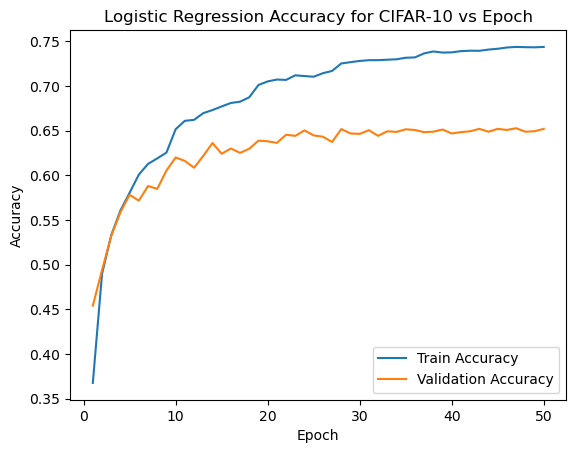

In [281]:
epochs = range(1, len(train_accuracies)+1)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN accuracy for CIFAR-10 vs Epoch")
plt.show()

In [285]:
test_loss, test_acc = evaluate(cnn_model_best, test_loader)
print(f"Test Accuracy: {test_acc}")

Test Accuracy: 0.6559533227848101


# Conclusions CNN

Overall decent results. We see the CNN model greatly increases the accuracy to roughly 65%. This was a good chance to work with more advanced hyperparameter tuning functions and train a relatively simple neural network while demonstrating the strength of CNNs. 

# Using pretrained networks (Transfer learning)

Instead of training a network from scratch, in this problem, we will use a network that has already been trained on a very large dataset (ImageNet) and adjust it for the task at hand. This process of adapting weights in a model trained for another task is known as transfer learning. To do so we will:
- Begin with the pretrained AlexNet model from torchvision.models for both tasks below. AlexNet achieved an early breakthrough performance on ImageNet and was instrumental in sparking the deep learning revolution in 2012.
-  Do not modify any module within AlexNet that is not the final classifier layer.
-  The output of AlexNet comes from the 6th layer of the classifier. Specifically, model.classifer[6] = nn.Linear(4096, 1000). To use AlexNet with CIFAR-10, we will reinitialize (replace) this layer with nn.Linear(4096, 10). This re-initializes the weights, and changes the output shape to reflect the desired number of target classes in CIFAR-10
- Afterwards we will train the entire model using the pretrained default weights as a starting point.

In [4]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 128

train_dataset, val_dataset = random_split(train_dataset, [int(0.9 * len(train_dataset)), int( 0.1 * len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [6]:
batch_size = 128

small_train_dataset, small_val_dataset, throw_away = random_split(train_dataset, [int(0.1 * len(train_dataset)), int( 0.1 * len(train_dataset)), int(0.8*len(train_dataset))])

# Create separate dataloaders for the train, test, and validation set
train_loader_small = DataLoader(
    small_train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader_small = DataLoader(
    small_val_dataset,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_small = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [13]:
model_alexnet = torchvision.models.alexnet(pretrained=True)
for param in model_alexnet.parameters():
    param.requires_grad = False
    
model_alexnet.classifier[6] = nn.Linear(4096, 10)
model_alexnet.to(DEVICE)

alexnet_optim = torch.optim.SGD(model_alexnet.parameters(), lr = 0.001)

In [10]:
train_losses_an, train_accuracies_an, val_losses_an, val_accuracies_an = train2(model = model_alexnet, optimizer = alexnet_optim, train_loader = train_loader_small, val_loader = val_loader_small, epochs = 10)

  0%|          | 0/10 [00:00<?, ?it/s]

train: 0.13976 	 val: 0.16428
train: 0.15213 	 val: 0.19423
train: 0.17231 	 val: 0.22396
train: 0.19271 	 val: 0.24327
train: 0.20681 	 val: 0.27582
train: 0.22287 	 val: 0.30143
train: 0.25239 	 val: 0.31836
train: 0.26845 	 val: 0.33746
train: 0.28342 	 val: 0.35265
train: 0.29536 	 val: 0.36328


In [22]:
#Seems to work so lets try to optuna it.
import torch.optim as optim
import optuna
from optuna.trial import TrialState

def Alexnet_objective(trial):
    #Potential hyper parameters
    initial_learning_rate = trial.suggest_float('initial_learning_rate', 0.0001, 0.01, log = True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    
    model = model_alexnet
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=initial_learning_rate)
    
    # Step decay schedule
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
        
    for epoch in range(10):
        train_losses, train_accuracies = train_epoch(model, optimizer, train_loader_small)
        val_losses, val_accuracies = batch_eval(model, val_loader_small)

        # Report intermediate results to Optuna
        trial.report(val_accuracies, epoch)

        # Prune trials that perform poorly based on intermediate results
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        lr_scheduler.step()

    return val_accuracies

study_alexnet = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
study_alexnet.optimize(Alexnet_objective, n_trials=30, show_progress_bar = True)

[I 2023-03-17 19:48:10,218] A new study created in memory with name: no-name-0accdf2c-9f86-476f-9077-800f95fe9562


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-03-17 19:51:35,061] Trial 0 finished with value: 67.35555555555555 and parameters: {'initial_learning_rate': 0.0043959950106556255, 'optimizer': 'SGD'}. Best is trial 0 with value: 67.35555555555555.
[I 2023-03-17 19:54:58,062] Trial 1 finished with value: 65.6 and parameters: {'initial_learning_rate': 0.005874128458640579, 'optimizer': 'Adam'}. Best is trial 0 with value: 67.35555555555555.
[I 2023-03-17 19:58:19,812] Trial 2 finished with value: 67.06666666666666 and parameters: {'initial_learning_rate': 0.005318510159030153, 'optimizer': 'SGD'}. Best is trial 0 with value: 67.35555555555555.
[I 2023-03-17 20:01:41,656] Trial 3 finished with value: 67.04444444444445 and parameters: {'initial_learning_rate': 0.0010504573489292033, 'optimizer': 'Adam'}. Best is trial 0 with value: 67.35555555555555.
[I 2023-03-17 20:05:02,938] Trial 4 finished with value: 67.31111111111112 and parameters: {'initial_learning_rate': 0.0002013172087291426, 'optimizer': 'SGD'}. Best is trial 0 with

In [27]:
model_alexnet = torchvision.models.alexnet(pretrained=True)
for param in model_alexnet.parameters():
    param.requires_grad = False
    
model_alexnet.classifier[6] = nn.Linear(4096, 10)
model_alexnet.to(DEVICE)

alexnet_optim_best = torch.optim.SGD(model_alexnet.parameters(), lr = 0.0017060344)

train_losses_an, train_accuracies_an, val_losses_an, val_accuracies_an = train2(model = model_alexnet, optimizer = alexnet_optim_best, train_loader = train_loader, val_loader = val_loader, epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

train: 0.45386 	 val: 0.54785
train: 0.53817 	 val: 0.57441
train: 0.56199 	 val: 0.59277
train: 0.57156 	 val: 0.60586
train: 0.57795 	 val: 0.61699
train: 0.5878 	 val: 0.61758
train: 0.58982 	 val: 0.62969
train: 0.59306 	 val: 0.62344
train: 0.59584 	 val: 0.61914
train: 0.59757 	 val: 0.63652
train: 0.60125 	 val: 0.63477
train: 0.60019 	 val: 0.63906
train: 0.60494 	 val: 0.63633
train: 0.60405 	 val: 0.64102
train: 0.60485 	 val: 0.6418
train: 0.60744 	 val: 0.64102
train: 0.60622 	 val: 0.64336
train: 0.60698 	 val: 0.6418
train: 0.61022 	 val: 0.64434
train: 0.60687 	 val: 0.6457


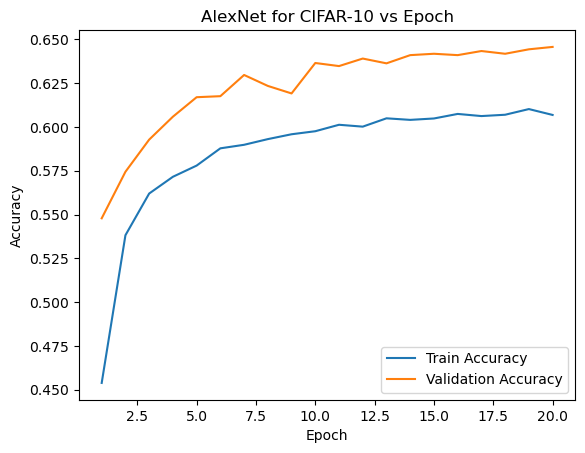

In [28]:
epochs = range(1, len(train_accuracies_an)+1)
plt.plot(epochs, train_accuracies_an, label="Train Accuracy")
plt.plot(epochs, val_accuracies_an, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("AlexNet for CIFAR-10 vs Epoch")
plt.show()

In [23]:
model_alexnet2 = torchvision.models.alexnet(pretrained=True)
model_alexnet2.classifier[6] = nn.Linear(4096, 10)
model_alexnet2.to(DEVICE)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [37]:
#Seems to be having issues.
# def Alexnet_objective2(trial):
#     #Potential hyper parameters
#     initial_learning_rate = trial.suggest_float('initial_learning_rate', 0.001, 0.03, log = True)
#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    
#     model = model_alexnet2
#     optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=initial_learning_rate)
    
#     # Step decay schedule
#     lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)
        
#     for epoch in range(10):
#         train_losses, train_accuracies = train_epoch(model, optimizer, train_loader_small)
#         val_losses, val_accuracies = batch_eval(model, val_loader_small)

#         # Report intermediate results to Optuna
#         trial.report(val_accuracies, epoch)

#         # Prune trials that perform poorly based on intermediate results
#         if trial.should_prune():
#             raise optuna.exceptions.TrialPruned()
        
#         lr_scheduler.step()

#     return val_accuracies

# study_alexnet2 = optuna.create_study(direction='maximize', pruner=optuna.pruners.HyperbandPruner())
# study_alexnet2.optimize(Alexnet_objective2, n_trials=30, show_progress_bar = True)

In [36]:
model_alexnet2 = torchvision.models.alexnet(pretrained=True)
model_alexnet2.classifier[6] = nn.Linear(4096, 10)
model_alexnet2.to(DEVICE)
alexnet_optim_best2 = torch.optim.SGD(model_alexnet2.parameters(), lr = 0.01)
train_losses_an2, train_accuracies_an2, val_losses_an2, val_accuracies_an2 = train2(model = model_alexnet2, optimizer = alexnet_optim_best2, train_loader = train_loader, val_loader = val_loader, epochs = 20)

  0%|          | 0/20 [00:00<?, ?it/s]

train: 0.58265 	 val: 0.72793
train: 0.76636 	 val: 0.74551
train: 0.8103 	 val: 0.80801
train: 0.83691 	 val: 0.82656
train: 0.85352 	 val: 0.83242
train: 0.86788 	 val: 0.83652
train: 0.87891 	 val: 0.84688
train: 0.88727 	 val: 0.85215
train: 0.89478 	 val: 0.86797
train: 0.91322 	 val: 0.8752
train: 0.91868 	 val: 0.86758
train: 0.92083 	 val: 0.86973
train: 0.92385 	 val: 0.87383
train: 0.92594 	 val: 0.87207
train: 0.92831 	 val: 0.87539
train: 0.93291 	 val: 0.87617
train: 0.93306 	 val: 0.87129
train: 0.93675 	 val: 0.88125
train: 0.94456 	 val: 0.87988
train: 0.94527 	 val: 0.88066


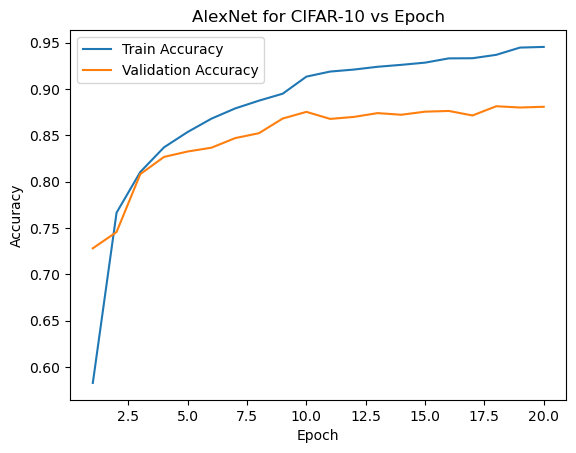

In [39]:
epochs = range(1, len(train_accuracies_an)+1)
plt.plot(epochs, train_accuracies_an2, label="Train Accuracy")
plt.plot(epochs, val_accuracies_an2, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("AlexNet for CIFAR-10 vs Epoch")
plt.show()

In [43]:
test_loss_an, test_acc_an = evaluate(model_alexnet, test_loader)
test_loss_an2, test_acc_an2 = evaluate(model_alexnet2, test_loader)

print(' alexnet unmodified accuracy: {:.3} \n alexnet modified accuracy: {:.3}'.format(test_acc_an, test_acc_an2))

 alexnet unmodified accuracy: 0.657 
 alexnet modified accuracy: 0.893


# Pretrained networks conclusions:

The AlexNet model worked extremely well. In particular the pretrained model with updated values based off our dataset achieved a very high accuracy. This really demonstrates the power of transfer learning. Additionally, the time to train these models on my pc (6gb vram 16g ram) really emphasises the difficulty in creating and tuning these more complex hyperparameters. It seems that tuning a pretrained model could be a good starting point for tackling many different types of problems.

# Overall Conclusions

We should pretty much never be training our own neural network from scratch. Some very large teams backed by significant funding have created starting parameters for most types of problems which can be tackled by NNs. Additionally, we were able to explore the useage of convolutions and maxpools to help our network classify.

This was super interesting to see just how long one of these networks takes to train on a single computer and to get a bit more experience implementing automated hyperparameter selection using Optuna bayesian search. 